### 분석에 필요한 패키지 Import

In [6]:
# 다음 코드의 주석을 해제하고 패키지를 설치해주세요.
!pip install xgboost lightgbm catboost scikit-learn --quiet

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 # random state 통일

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    VotingClassifier,
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, StackingClassifier
)
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

### 데이터 로드

In [10]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.read_csv('Employee.csv')

In [11]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [12]:
target = 'LeaveOrNot'

In [13]:
X = df.drop(target, axis = 1) # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [16]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [17]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.

cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.fit_transform(X[col].astype(str))

In [18]:
# 스케일링

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [20]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y, 
    random_state=SEED
)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [26]:
# 모델을 불러와 훈련시킵니다.
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [27]:
# 모델을 통해 예측을 수행합니다.
y_lr_pred = lr.predict(X_test)

In [28]:
# 계산된 예측값에 대해 정확도를 계산합니다.
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [30]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [31]:
y_tree_pred = tree.predict(X_test)

In [32]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8359106529209622
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.74       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [34]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [35]:
y_svm_pred = svm.predict(X_test)

In [36]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8548109965635738
Report :
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       775
           1       0.91      0.63      0.74       389

    accuracy                           0.85      1164
   macro avg       0.87      0.80      0.82      1164
weighted avg       0.86      0.85      0.85      1164



#### 4. kNN

In [38]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
y_knn_pred = knn.predict(X_test)

In [40]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8298969072164949
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       775
           1       0.82      0.63      0.71       389

    accuracy                           0.83      1164
   macro avg       0.83      0.78      0.80      1164
weighted avg       0.83      0.83      0.82      1164



#### 네 가지 단일 모델의 결과 비교

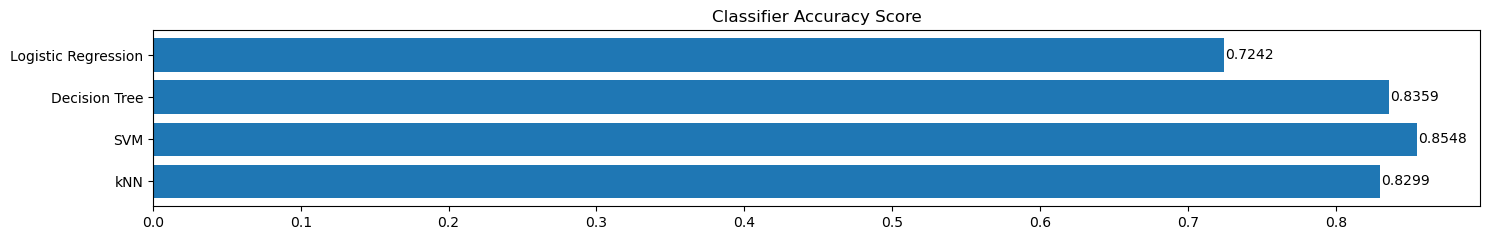

In [42]:
model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [46]:
# estimators 인자로 들어갈 분류기 리스트를 지정합니다.
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [47]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators= models, 
    voting= 'hard'
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8505


### 2. Bagging

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [50]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.fit(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.predict(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8540


### 3. Boosting

#### 3.1 AdaBoost

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [53]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8239


#### 3.2 GBM

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [55]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [57]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8608


#### 3.4 LightGBM

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [59]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8582


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [61]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

CatBoost Accuracy: 0.8600


### 4. Stacking

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [64]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator = LogisticRegression(random_state = SEED), # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8565


## [과제] 모델 성능을 높여봅시다!

이제 직접 다른 전처리 기법, 피쳐 엔지니어링, 앙상블 기법, 추가 하이퍼파라미터 튜닝 등등.. 을 수행해서 더 높은 정확도를 가지는 모델을 만들어보세요.\
다양한 방법을 수행해보고, 비교한 후 결과를 정리해서 마크다운으로 남겨주시면 되겠습니다! 이때 각 단계별로 어떤 방법을 수행했는지에 대한 설명을 꼭 달아주세요.

- 정확도는 소수점 자릿수 제한 없이 모두 출력합니다.

## 성능 시각화하여 비교해보기

In [68]:
Voting_Accuracy =  accuracy_score(y_test, y_voting_pred)
Random_Forest_Accuracy =  accuracy_score(y_test, y_rf_pred)
AdaBoost_Accuracy = accuracy_score(y_test, y_ada_pred)
GBM_Accuracy = accuracy_score(y_test, y_gbm_pred)
XGBoost_Accuracy = accuracy_score(y_test, y_xgb_pred)
LightGBM_Accuracy = accuracy_score(y_test, y_lgbm_pred)
CatBoost_Accuracy = accuracy_score(y_test, y_cb_pred)
Stacking_Accuracy = accuracy_score(y_test, y_stk_pred)

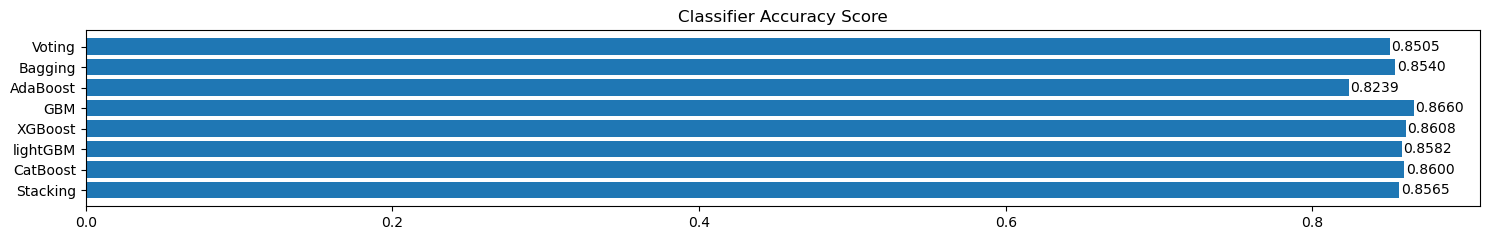

In [69]:
model_name = ['Voting', 'Bagging', 'AdaBoost', 'GBM', 'XGBoost', 'lightGBM', 'CatBoost', 'Stacking']
accuracy_scores = [Voting_Accuracy, Random_Forest_Accuracy, AdaBoost_Accuracy, GBM_Accuracy, XGBoost_Accuracy, LightGBM_Accuracy, CatBoost_Accuracy, Stacking_Accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

In [70]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


### 전처리 확인해보기
- 딱히

In [72]:
X.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
dtype: int64

In [73]:
df[df['ExperienceInCurrentDomain'] == 0]

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
5,Bachelors,2016,Bangalore,3,22,Male,No,0,0
6,Bachelors,2015,New Delhi,3,38,Male,No,0,0
18,Bachelors,2015,Pune,2,30,Female,No,0,1
19,Bachelors,2016,New Delhi,2,22,Female,No,0,1
...,...,...,...,...,...,...,...,...,...
4635,Bachelors,2014,Bangalore,3,22,Female,No,0,0
4636,Masters,2014,New Delhi,3,37,Female,No,0,1
4639,Bachelors,2017,Bangalore,3,28,Male,No,0,1
4640,Bachelors,2015,Bangalore,3,35,Male,No,0,0


### GBM, XGBoost, LightGBM, CatBoost에 대하여 하이퍼파라미터 튜닝(GridSearchSCV)을 실시한 후 stacking으로 최적의 모델을 찾기

In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [76]:
# GBM 하이퍼 파라미터 튜닝
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search_gbm = GridSearchCV(estimator=gbm, param_grid=param_grid_gbm, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_gbm.fit(X_train, y_train)

print(f"Best parameters for GBM: {grid_search_gbm.best_params_}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for GBM: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}


In [77]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


In [78]:
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'num_leaves': [31, 50, 100],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search_lgb = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)

print(f"Best parameters for LightGBM: {grid_search_lgb.best_params_}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for LightGBM: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}


In [79]:
param_grid_cb = {
    'iterations': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}

grid_search_cb = GridSearchCV(estimator=cb, param_grid=param_grid_cb, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_cb.fit(X_train, y_train)

print(f"Best parameters for CatBoost: {grid_search_cb.best_params_}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters for CatBoost: {'depth': 5, 'iterations': 100, 'learning_rate': 0.1, 'subsample': 0.7}


### best parameters로 모델 생성하여 성능 확인하기

In [81]:
# 모델 생성
gbm = GradientBoostingClassifier(**grid_search_gbm.best_params_)

# 모델 훈련
gbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.predict(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8754


In [82]:
# 모델 생성
xgboost = xgb.XGBClassifier(**grid_search_xgb.best_params_)

# 모델 훈련
xgboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.predict(X_test)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8711


In [83]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.LGBMClassifier(**grid_search_lgb.best_params_)

# 모델 훈련
lgbm.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.predict(X_test)

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8565


In [84]:
# 모델 생성
cb = CatBoostClassifier(**grid_search_cb.best_params_)

# 모델 훈련
cb.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.predict(X_test)

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(y_test, y_cb_pred):.4f}")

0:	learn: 0.6511219	total: 2.21ms	remaining: 219ms
1:	learn: 0.6206755	total: 5.27ms	remaining: 258ms
2:	learn: 0.5945069	total: 9.24ms	remaining: 299ms
3:	learn: 0.5698039	total: 12.6ms	remaining: 302ms
4:	learn: 0.5522561	total: 15.3ms	remaining: 291ms
5:	learn: 0.5356254	total: 17.9ms	remaining: 280ms
6:	learn: 0.5184299	total: 21.2ms	remaining: 282ms
7:	learn: 0.5037640	total: 23.6ms	remaining: 272ms
8:	learn: 0.4916433	total: 26.2ms	remaining: 265ms
9:	learn: 0.4807530	total: 29.4ms	remaining: 264ms
10:	learn: 0.4719533	total: 33ms	remaining: 267ms
11:	learn: 0.4635061	total: 36.5ms	remaining: 268ms
12:	learn: 0.4580051	total: 40.1ms	remaining: 268ms
13:	learn: 0.4518697	total: 42.2ms	remaining: 259ms
14:	learn: 0.4486028	total: 46.3ms	remaining: 262ms
15:	learn: 0.4449949	total: 50.5ms	remaining: 265ms
16:	learn: 0.4413664	total: 53.1ms	remaining: 259ms
17:	learn: 0.4367013	total: 55.4ms	remaining: 252ms
18:	learn: 0.4329316	total: 58.2ms	remaining: 248ms
19:	learn: 0.4295205	tot

## Stacking 최적 하이퍼파라미터 튜닝한 모델들로 조합해 최적 메타모델 학습해보기
- LogisticRegression
- SVC
- RandomForestClassifier
- GradientBoostingClassifier
- XGBClassifier

In [86]:
## Stacking - SVC
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=SVC(probability=True), cv = 5)

# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8745704467353952


In [87]:
## Stacking - RandomForestClassifier
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv = 5)

# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8668384879725086


In [88]:
## Stacking - GradientBoostingClassifier
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(), cv = 5)

# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8762886597938144


In [89]:
from xgboost import XGBClassifier

## Stacking - XGBClassifier
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator= XGBClassifier(), cv = 5)

# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8642611683848798


In [90]:
from sklearn.neural_network import MLPClassifier

## Stacking - SVC
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator= MLPClassifier(), cv = 5)

# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8754295532646048


In [91]:
## Stacking - logisticRegression
estimators = [
    ('gbm', grid_search_gbm.best_estimator_),
    ('xgb', grid_search_xgb.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_),
    ('catboost', grid_search_cb.best_estimator_)
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv = 5)

In [92]:
# Stacking 모델 훈련
stacking_model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stack_pred = stacking_model.predict(X_test)

# 성능 평가
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_stack_pred)}")

Stacking Model Accuracy: 0.8797250859106529


In [93]:
from sklearn.model_selection import cross_val_score

# 전체 스택 모델에 대해 교차 검증 수행
stacking_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='accuracy')

print(f"Stacking CV Accuracy 평균: {stacking_scores.mean():.4f}")
print(f"각 fold별 정확도: {stacking_scores}")

Stacking CV Accuracy 평균: 0.8464
각 fold별 정확도: [0.83524355 0.85530086 0.8495702  0.84527221 0.84648494]


In [94]:
GBM_Accuracy1 =  accuracy_score(y_test, y_gbm_pred)
XGBoost_Accuracy1 = accuracy_score(y_test, y_xgb_pred)
LightGBM_Accuracy1 = accuracy_score(y_test, y_lgbm_pred)
CatBoost_Accuracy1 = accuracy_score(y_test, y_cb_pred)
Stacking_Model_Accuracy1 = accuracy_score(y_test, y_stack_pred)
model_name.extend(['GBM_optimized', 'XGBoost_optimized', 'lightGBM_optimized', 'CatBoost_optimized', 'Stacking_optimized'])
accuracy_scores.extend([GBM_Accuracy1, XGBoost_Accuracy1, LightGBM_Accuracy1, CatBoost_Accuracy1, Stacking_Model_Accuracy1])

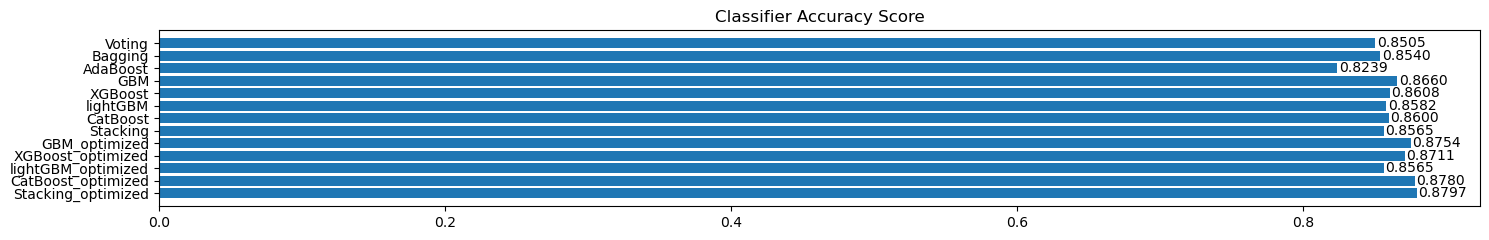

In [95]:
plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 결론
하이퍼파리미터 최적화 후 Stacking - logisticRegression 사용 모델이 젤 성능이 좋음. "0.8797250859106529"   
데이터가 수가 많지 않고 변수간 복잡한 비선형 관계가 아니여서 logisticRegression으로 충분히 좋은 성능을 갖는 듯하다.  
교차 검증 결과, 각 Fold별 정확도가 전체 스택 모델의 정확도와 비슷하여 과적합 문제 없다고 할 수 있을 듯하다.